In [1]:
from glob import glob
import os
import numpy
import matplotlib.pyplot as plt
% matplotlib inline
import dlib
import skimage.transform

In [2]:
def find_subjs_w_misssed_frames(fail_vec_path):
    fail_vec_file_list = sorted(glob(os.path.join(fail_vec_path, 'fail_vec*')))
    # print fail_vec_file_list
    
    for fail_vec_file in fail_vec_file_list:
        subj = os.path.split(fail_vec_file)[1].strip('.npy').split('_')[2]        
        fail_vec = numpy.load(fail_vec_file)
        num_faces_missed = numpy.sum(fail_vec)
        print 'Subj: %s -- Num Faces Missed: %d' % (subj, num_faces_missed)

In [3]:
def detect_face_dlib(frame):
    num_landmarks = 68
    predictor_path = '/var/research/Code/dlib-18.17/python_examples/' \
                     'shape_predictor/shape_predictor_68_face_landmarks.dat'

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    det = detector(frame, 1)

    if det:
        det = det[0]
        detect_flag = 1
        landmarks = []
        shape = predictor(frame, det)
        for i in range(num_landmarks):
            part = shape.part(i)
            landmarks.append(part.x)
            landmarks.append(part.y)
        landmarks = numpy.array(landmarks, dtype='float32')
    else:
        detect_flag = 0
        landmarks = numpy.zeros((2*num_landmarks), dtype='float32')

    # print detect_flag, landmarks

    return detect_flag, landmarks


def crop_frame_using_landmarks(frame, landmarks):
    """ Function to crop the face using the detected facial
    landmarks (courtesy of dlib)."""

    landmarks = numpy.reshape(landmarks, (2, len(landmarks)/2), 'F')
    min_x = numpy.min(landmarks[0, :])
    min_y = numpy.min(landmarks[1, :])-30  # include more of the brow
    max_x = numpy.max(landmarks[0, :])
    max_y = numpy.max(landmarks[1, :])

    # print min_x, max_x
    # print min_y, max_y
    crop_frame = frame[min_y:max_y, min_x:max_x, :]
    bb = (min_x, min_y, max_x-min_x, max_y-min_y)
    return crop_frame, bb

In [4]:
def fill_in_missed_frames(subj_id, orig_face_path, crop_face_path, save_path):
    X_orig = numpy.load(os.path.join(orig_face_path, 'X_'+subj_id+'.npy'))
    X_crop = numpy.load(os.path.join(crop_face_path, 'X_'+subj_id+'.npy'))
    fail_vec = numpy.load(os.path.join(crop_face_path, 'fail_vec_'+subj_id+'.npy'))
    
    print X_orig.shape
    print X_crop.shape
    print 'Num Frames Missed: ', numpy.sum(fail_vec)
    
    fail_inds = numpy.where(fail_vec == 1)[0]
    print 'Indices of missed frames: ', fail_inds
    
    # Calculate number of all-zero images (should be equal to number of fail_inds==1)
    # num_zero_imgs_before = numpy.sum(numpy.sum(X_crop, axis=(1,2,3)) == 0)
    # print 'Number of all-zero images before: ', num_zero_imgs_before    
    
    det_flag, landmarks_good = detect_face_dlib(X_orig[fail_inds[0]-1, :, :, :])
    
    for fail_ind in fail_inds:        
        orig_frame = X_orig[fail_ind, :]
        crop_frame, bb = crop_frame_using_landmarks(orig_frame, landmarks_good)
    
        print 'Showing original frame %d' % fail_ind
        plt.imshow(orig_frame)
        plt.show()
    
        print 'Cropped frame using landmarks from good detection'
        plt.imshow(crop_frame)
        plt.show()
        
        crop_frame_r = skimage.transform.resize(crop_frame, (96, 96))
        crop_frame_r = numpy.uint8(crop_frame_r*255.0)        
        X_crop[fail_ind, :, :, :] = crop_frame_r.transpose(2, 0, 1)
        
    # Calculate number of all-zero images after replacement (should be 0)
    # num_zero_imgs_after = numpy.sum(numpy.sum(X_crop, axis=(1,2,3)) == 0)
    # print 'Number of all-zero images after: ', num_zero_imgs_after
    
    print 'Saving filled in frames.'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    numpy.save(os.path.join(save_path, 'X_'+subj_id+'.npy'), X_crop)

In [5]:
def replace_frame(subj_id, crop_face_path, save_path):    
    X_crop = numpy.load(os.path.join(crop_face_path, 'X_'+subj_id+'.npy'))
    fail_vec = numpy.load(os.path.join(crop_face_path, 'fail_vec_'+subj_id+'.npy'))
        
    print X_crop.shape
    print 'Num Frames Missed: ', numpy.sum(fail_vec)
    
    fail_inds = numpy.where(fail_vec == 1)[0]
    print 'Indices of missed frames: ', fail_inds
    
    # Calculate number of all-zero images (should be equal to number of fail_inds==1)
    # num_zero_imgs_before = numpy.sum(numpy.sum(X_crop, axis=(1,2,3)) == 0)
    # print 'Number of all-zero images before: ', num_zero_imgs_before    
    
    for fail_ind in fail_inds:                
        rep_img = X_crop[fail_ind-1, :, :, :]
        X_crop[fail_ind, :, :, :] = rep_img
    
    print 'Saving filled in frames.'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    numpy.save(os.path.join(save_path, 'X_'+subj_id+'.npy'), X_crop)    

In [6]:
orig_face_path = '/data/Expr_Recog/Chen_Huang_avdata_python/npy_files/indiv/npy_files_raw/'
crop_face_path = '/data/Expr_Recog/Chen_Huang_avdata_python/npy_files/indiv/npy_files_faces_cropped/'
save_path = './fixed_npy_files/'

In [7]:
find_subjs_w_misssed_frames(crop_face_path)

Subj: 03 -- Num Faces Missed: 0
Subj: 04 -- Num Faces Missed: 0
Subj: 07 -- Num Faces Missed: 1
Subj: 16 -- Num Faces Missed: 0
Subj: 18 -- Num Faces Missed: 15
Subj: 19 -- Num Faces Missed: 0
Subj: 26 -- Num Faces Missed: 0
Subj: 31 -- Num Faces Missed: 0
Subj: 37 -- Num Faces Missed: 0
Subj: 46 -- Num Faces Missed: 0
Subj: 56 -- Num Faces Missed: 0
Subj: 61 -- Num Faces Missed: 0
Subj: 68 -- Num Faces Missed: 0
Subj: 78 -- Num Faces Missed: 0
Subj: 81 -- Num Faces Missed: 0
Subj: 82 -- Num Faces Missed: 0
Subj: 85 -- Num Faces Missed: 0
Subj: 87 -- Num Faces Missed: 0
Subj: 90 -- Num Faces Missed: 0
Subj: 94 -- Num Faces Missed: 0


(3033, 240, 352, 3)
(3033, 3, 96, 96)
Num Frames Missed:  15
Indices of missed frames:  [982 983 984 985 986 987 988 989 990 991 992 993 994 995 996]
Showing original frame 982


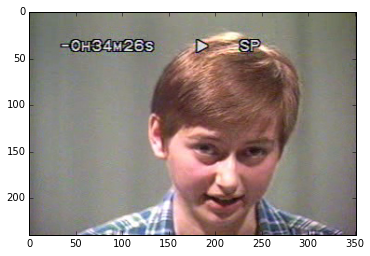

Cropped frame using landmarks from good detection


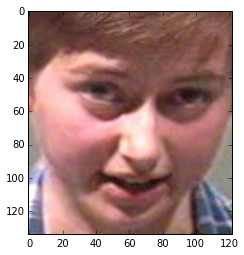

Showing original frame 983


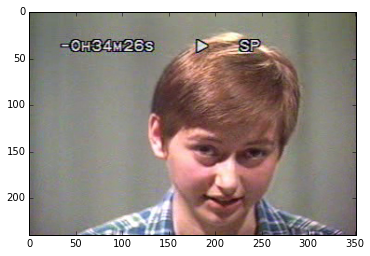

Cropped frame using landmarks from good detection


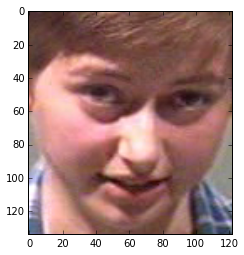

Showing original frame 984


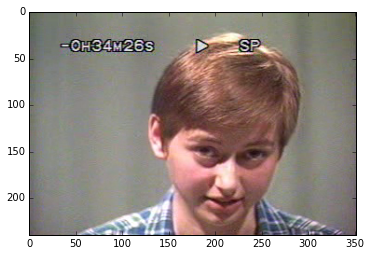

Cropped frame using landmarks from good detection


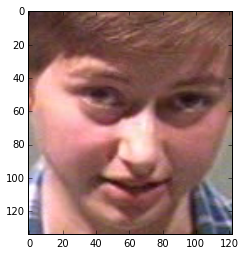

Showing original frame 985


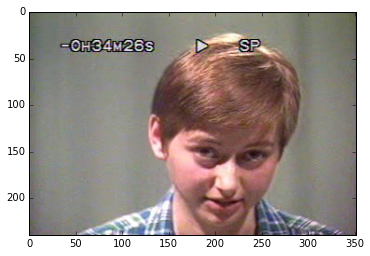

Cropped frame using landmarks from good detection


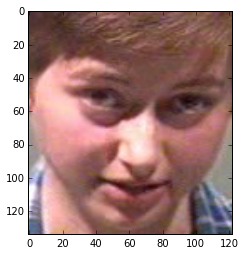

Showing original frame 986


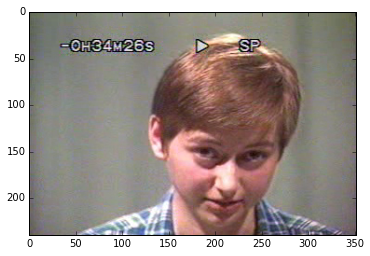

Cropped frame using landmarks from good detection


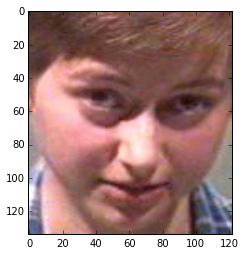

Showing original frame 987


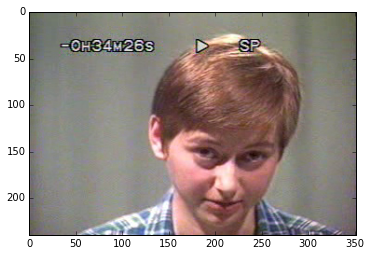

Cropped frame using landmarks from good detection


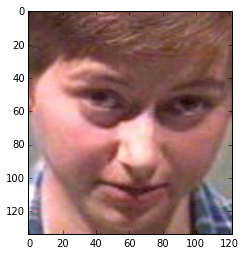

Showing original frame 988


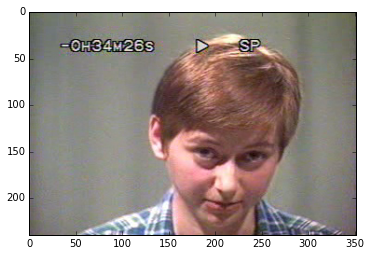

Cropped frame using landmarks from good detection


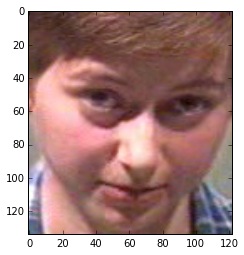

Showing original frame 989


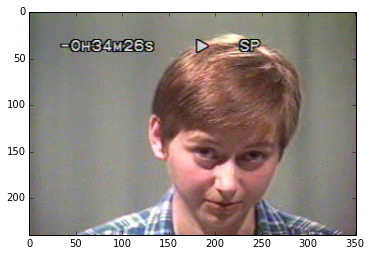

Cropped frame using landmarks from good detection


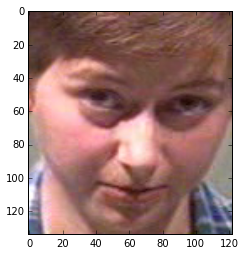

Showing original frame 990


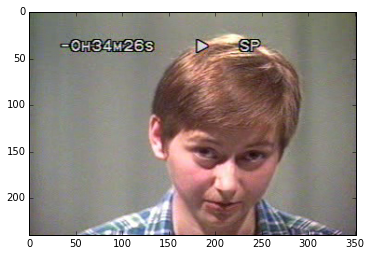

Cropped frame using landmarks from good detection


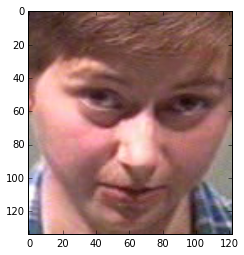

Showing original frame 991


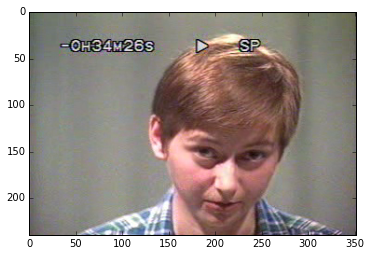

Cropped frame using landmarks from good detection


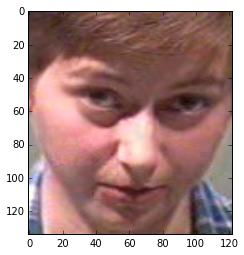

Showing original frame 992


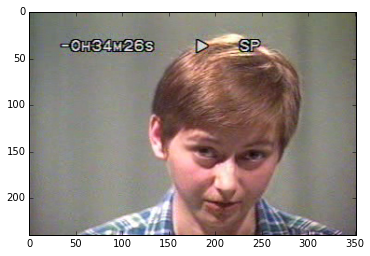

Cropped frame using landmarks from good detection


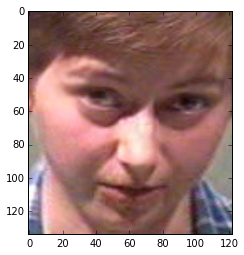

Showing original frame 993


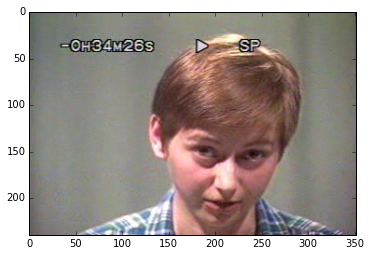

Cropped frame using landmarks from good detection


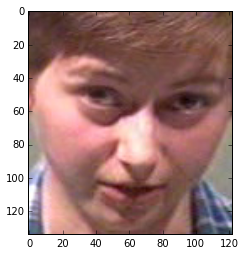

Showing original frame 994


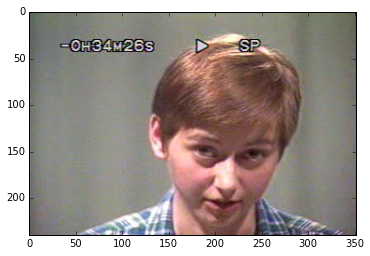

Cropped frame using landmarks from good detection


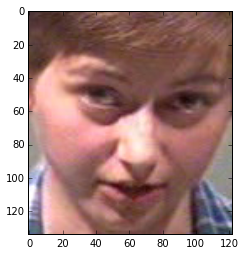

Showing original frame 995


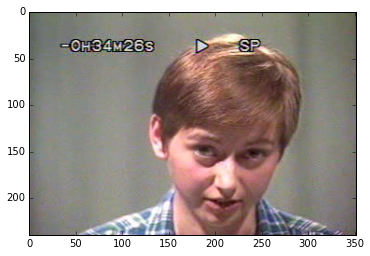

Cropped frame using landmarks from good detection


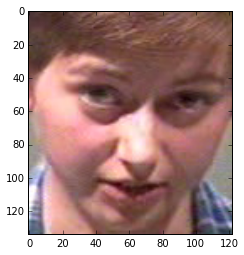

Showing original frame 996


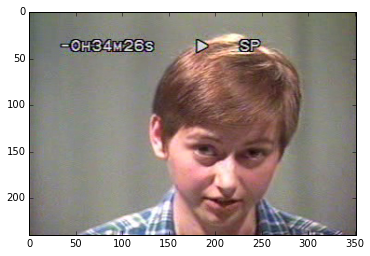

Cropped frame using landmarks from good detection


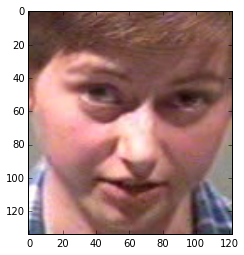

Saving filled in frames.


In [8]:
fill_in_missed_frames('18', orig_face_path, crop_face_path, save_path)

In [9]:
replace_frame('07', crop_face_path, save_path)

(3179, 3, 96, 96)
Num Frames Missed:  1
Indices of missed frames:  [1527]
Saving filled in frames.


In [13]:
# Ensure there are no zero frames left
X_07 = numpy.load('./fixed_npy_files/X_07.npy')
print X_07.shape
print numpy.sum(numpy.sum(X_07, axis=(1,2,3))!=0)

(3179, 3, 96, 96)
3179


In [14]:
# Ensure there are no zero frames left
X_18 = numpy.load('./fixed_npy_files/X_18.npy')
print X_18.shape
print numpy.sum(numpy.sum(X_18, axis=(1,2,3))!=0)

(3033, 3, 96, 96)
3033


In [ ]:
subj_id = '18'

fail_vec = numpy.load(os.path.join(crop_face_path, 'fail_vec_'+subj_id+'.npy'))
print 'Num Frames Missed: ', numpy.sum(fail_vec)

In [ ]:
fail_inds = numpy.where(fail_vec == 1)[0]
print fail_inds

In [ ]:
X_orig = numpy.load(os.path.join(orig_face_path, 'X_'+subj_id+'.npy'))
X_crop = numpy.load(os.path.join(crop_face_path, 'X_'+subj_id+'.npy'))

print X_orig.shape
print X_crop.shape

In [ ]:
for fail_ind in fail_inds:
    print 'Showing frame: %d' % fail_ind
    orig_frame = X_orig[fail_ind, :]
    plt.imshow(orig_frame)
    plt.show()

In [ ]:
det_flag, landmarks = detect_face_dlib(X_orig[980, :, :, :])
crop_face, bb = crop_frame_using_landmarks(X_orig[980, :, :, :], landmarks)

print det_flag, bb
plt.imshow(crop_face)
plt.show()

In [ ]:
for fail_ind in fail_inds:
    print 'Showing frame: %d' % fail_ind
    orig_frame = X_orig[fail_ind, :]
    
    crop_frame, bb = crop_frame_using_landmarks(orig_frame, landmarks)
    
    plt.imshow(orig_frame)
    plt.show()
    
    plt.imshow(crop_frame)
    plt.show()

In [ ]:
X_07 = numpy.load('./fixed_npy_files/X_07.npy')

plt.imshow(X_07[1526, :, :, :].transpose(1, 2, 0))
plt.title('Frame 1526')
plt.show()

plt.imshow(X_07[1527, :, :, :].transpose(1, 2, 0))
plt.title('Frame 1527')
plt.show()

plt.imshow(X_07[1528, :, :, :].transpose(1, 2, 0))
plt.title('Frame 1528')
plt.show()

plt.imshow(X_07[1529, :, :, :].transpose(1, 2, 0))
plt.title('Frame 1529')
plt.show()